# 2D plotting of LES output vs. synthetic aperture radar (work in progress)
## Updated as of 6/24/25
* The below notebook compares selected simulations against observational targets that were collected from satellite.
* Figure 7 is generated from this notebook
* In case of questions or concerns, please notify Ann Fridlind (ann.fridlind@nasa.gov), Timothy Juliano (tjuliano@ucar.edu), and Florian Tornow (ft2544@columbia.edu).

In [1]:

import glob, os
import geopy
import geopy.distance

os.getcwd()


'/user-data-home/comble-mip/notebooks/plotting/paper'

In [2]:
os.chdir("/user-data-home/comble-mip/notebooks/plotting/")

%run functions_plotting.py 

## read trajectory
ds = nc.Dataset('../../data_files/theta_temp_rh_sh_uvw_sst_along_trajectory_era5ml_28h_end_2020-03-13-18.nc')
les_time = 18. + ds['Time'][:]
    
## select simulations to plot
sim_keyword = 'FixN_2D'  

## Ancillary info

In [3]:
## select times -- we set this below
#Time_Vec = [1.,2.,3.,4.,5.,6.] ## hours, where 18 h marks arrival

## select acceptable window of time
Time_Window = 15.0  ## hours

## set domain to be extracted
Spat_Window = 100.0 ## km

## downscale to 1 km resolution (default: True)
upscale = True

## repeat small domain output to match large domain (default: False)
tiling = False

## Load LES outputs

In [4]:
os.chdir("/user-data-home/comble-mip/notebooks/plotting/")
%run functions_plotting.py 

var_vec_2d = ['us','vs']

## load all simulations located in subfolders of the given directory
Time_Vec_model = [4.,16.]
if upscale:
    df_col_2d = load_sims_2d('/data/project/comble-mip/output_les/',var_vec_2d,t_shift=-2,keyword=sim_keyword,times=[t for t in Time_Vec_model if t > 0],coarsen=False)
    df_col_2d['x'] = np.round(df_col_2d['x']/1000,1)
    df_col_2d['y'] = np.round(df_col_2d['y']/1000,1)
    df_col_2d = df_col_2d.rename({'y':'y_round','x':'x_round'})
else:
    df_col_2d = load_sims_2d('/data/project/comble-mip/output_les/',var_vec_2d,t_shift=-2,keyword=sim_keyword,times=[t for t in Time_Vec_model if t > 0],coarsen=True)

Loading variables: f(time,x,y)
/data/project/comble-mip/output_les/wrf/WRF_Lx25_dx100_FixN_2D.nc


ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


/data/project/comble-mip/output_les/dharma/DHARMA_Lx125_dx100_FixN_2D.nc
/data/project/comble-mip/output_les/dharma/DHARMA_Lx25_dx100_FixN_2D.nc
/data/project/comble-mip/output_les/uclales-salsa/UCLALES-SALSA_Lx25_dx100_FixN_2D.nc
...adjusting x and y values


## Load SAR imagery

In [5]:
sar_dir = "/data/project/comble-mip/sar_imagery/"
os.chdir(sar_dir)
counter_dat = 0
for file in sorted(glob.glob("*wind_level2.nc")):
    print (file)
    
    ## select times
    if "06_09_06" in str(file):
        Time_Vec = [10.] ## hours, where 18 h marks arrival
    elif "06_56_19" in str(file): ## USING THIS FOR PAPER
        Time_Vec = [4.]
    elif "16_39_47" in str(file):
        Time_Vec = [17.]
    elif "16_40_12" in str(file): ## USING THIS FOR PAPER
        #Time_Vec = [17.]
        Time_Vec = [16.]
        
    ## convert to regular time
    tprop = []
    for toi in Time_Vec:
        tprop.append(np.datetime64('2020-03-13T00:00:00') + np.timedelta64(int(toi),'h'))
    print (tprop)
    
    ## load file
    ds_sar = xr.open_dataset(sar_dir + file)
    
    ## shift eastward downstream to cover LES domain
    if "16_39_47" in str(file):
        ds_sar['longitude'] = ds_sar['longitude']+1.
    elif "16_40_12" in str(file):
        ds_sar['longitude'] = ds_sar['longitude']+2.
    
    ## time
    file_time = ds_sar['acquisition_time'].data
    
    ## for each requested model timestep, check if image covers right place at right time
    counter_time = 0
    for Time_OI in tprop:
        diff_time = (file_time - np.datetime64(Time_OI))/np.timedelta64(1, 's')/3600
        if np.abs(diff_time) <= Time_Window:
            print(Time_OI)
            Traj_time = (Time_OI - np.datetime64('2020-03-13T18:00:00'))/np.timedelta64(1, 's')/3600
            Lat_OI = ds['Latitude'][ds['Time'][:]==Traj_time][0]
            Lon_OI = ds['Longitude'][ds['Time'][:]==Traj_time][0]
            
            ## create spatial window around coordinate of interest
            start = geopy.Point(Lat_OI, Lon_OI)
            d = geopy.distance.distance(kilometers=1.2*Spat_Window/2)
            
            LAT_MIN = d.destination(point=start, bearing=180)[0]
            LAT_MAX = d.destination(point=start, bearing=0)[0]
            LON_MIN = d.destination(point=start, bearing=270)[1]
            LON_MAX = d.destination(point=start, bearing=90)[1]
            
            #print(LAT_MIN,LAT_MAX,LON_MIN,LON_MAX)
            
            SliceData = ds_sar.where((ds_sar['latitude'][:,:] > LAT_MIN) & 
                                     (ds_sar['latitude'][:,:] < LAT_MAX) & 
                                     (ds_sar['longitude'][:,:] > LON_MIN)& 
                                     (ds_sar['longitude'][:,:] < LON_MAX),drop=True)
            #print (SliceData['latitude'])
            
            ## select pixels within window
            pix_num = ((ds_sar['latitude'][:,:] > LAT_MIN) & 
                       (ds_sar['latitude'][:,:] < LAT_MAX) & 
                       (ds_sar['longitude'][:,:] > LON_MIN)& 
                       (ds_sar['longitude'][:,:] < LON_MAX)).sum()
            #print(pix_num)
            
            if pix_num > 0:
                
                ds_wind = SliceData['sar_wind'][:,:]
                ds_lat = SliceData['latitude'][:,:]
                ds_lon = SliceData['longitude'][:,:]
                
                da = xr.DataArray(
                    name = 'wspd',
                    data = ds_wind,
                    dims = ['y_dist','x_dist'],
                    coords = dict(
                        lon = (['y_dist','x_dist'],ds_lon.data),
                        lat = (['y_dist','x_dist'],ds_lat.data)
                    ))
            
                ## compute meridional and latitudal distance to center
                da['x_dist'] = 0*da['lat']
                da['y_dist'] = 0*da['lat']
                print (ds_wind.shape)
                for jj in tqdm(range(ds_wind.shape[0])):
                    for ii in range(ds_wind.shape[1]):
                        da['x_dist'][jj,ii] = geopy.distance.geodesic((da['lat'][jj,ii],da['lon'][jj,ii]), 
                                                                      (da['lat'][jj,ii],Lon_OI)).km * np.sign((da['lon'][jj,ii].data - Lon_OI))
                        da['y_dist'][jj,ii] = geopy.distance.geodesic((da['lat'][jj,ii],da['lon'][jj,ii]), 
                                                                      (Lat_OI,da['lon'][jj,ii])).km * np.sign((da['lat'][jj,ii].data - Lat_OI)) 
                
                ## limit to requested size
                da = da.where((np.abs(da['y_dist'][:,:]) <= Spat_Window/2) & (np.abs(da['x_dist'][:,:]) <= Spat_Window/2),drop=True)
                
                ## consolidate data by rounding x and y dimensions
                da['x_round'] = np.round(da['x_dist'])
                da['y_round'] = np.round(da['y_dist'])
                
                print (da['x_round'])
                
                ## create new data array that we're going to fill
                da_stat_stack = xr.DataArray(name='wspd',coords=(np.unique(da['y_round']),np.unique(da['x_round'])))
                da_stat_stack = da_stat_stack.rename({'dim_0': 'y_round','dim_1': 'x_round'})
                
                ## loop through each 2D grid cell and compute mean after grouping into new "rounded" arrays
                countyy = -1
                for yy in tqdm(np.unique(da['y_round'])):
                    countxx = -1
                    for xx in np.unique(da['x_round']):
                        da_sub = da.where((da['y_round'] == yy) & (da['x_round'] == xx),drop=True)
                        da_stat = da_sub.mean()
                        da_stat['y_round'] = np.float64(yy)
                        da_stat['x_round'] = np.float64(xx)

                        da_stat_stack[countyy,countxx] = da_stat

                        countxx+=-1

                    countyy+=-1
                
                if upscale:
                    x_round_new = np.round(np.linspace(da_stat_stack.x_round[0], da_stat_stack.x_round[-1], 10*len(da_stat_stack['x_round'])-9),1) # da_stat_stack["x_round"] * 4)
                    y_round_new = np.round(np.linspace(da_stat_stack.y_round[0], da_stat_stack.y_round[-1], 10*len(da_stat_stack['y_round'])-9),1) # da_stat_stack["x_round"] * 4)
                    da_stat_stack = da_stat_stack.interp(x_round=x_round_new,y_round=y_round_new)
                
                da_stat_stack['time'] = Time_OI
                da_stat_stack['time_diff'] = diff_time
                if counter_time == 0:
                    da_stat_stst = xr.concat([da_stat_stack],dim='time')
                else:
                    da_stat_stst = xr.concat([da_stat_stst,da_stat_stack],dim='time')
                counter_time += 1
                
    da_stat_stst['Source'] = file
    if counter_dat == 0:
        da_stat_ststst = xr.concat([da_stat_stst],dim='Source')
    else:
        da_stat_ststst = xr.concat([da_stat_ststst,da_stat_stst],dim='Source')
    counter_dat += 1

S1B_ESA_2020_03_13_06_56_19_0637397779_006.43E_78.04N_HH_C5_GFS05CDF_wind_level2.nc
[numpy.datetime64('2020-03-13T04:00:00')]
2020-03-13T04:00:00
(290, 318)


100%|██████████| 290/290 [01:13<00:00,  3.94it/s]


<xarray.DataArray 'x_round' (y_dist: 260, x_dist: 265)> Size: 276kB
array([[ 86.,  86.,  86., ..., -33., -34., -34.],
       [ 86.,  86.,  85., ..., -34., -34., -35.],
       [ 86.,  86.,  85., ..., -34., -34., -35.],
       ...,
       [ 34.,  33.,  33., ..., -84., -84., -85.],
       [ 33.,  33.,  33., ..., -84., -85., -85.],
       [ 33.,  33.,  32., ..., -84., -85., -85.]], dtype=float32)
Coordinates:
    lon      (y_dist, x_dist) float32 276kB 10.5 10.48 10.47 ... 3.847 3.829
    lat      (y_dist, x_dist) float32 276kB 76.97 76.98 76.98 ... 76.36 76.36
    x_dist   (y_dist, x_dist) float32 276kB 86.49 86.04 85.58 ... -84.69 -85.15
    y_dist   (y_dist, x_dist) float32 276kB 32.07 32.3 32.53 ... -36.18 -36.01
    x_round  (y_dist, x_dist) float32 276kB 86.0 86.0 86.0 ... -84.0 -85.0 -85.0
    y_round  (y_dist, x_dist) float32 276kB 32.0 32.0 33.0 ... -36.0 -36.0 -36.0


100%|██████████| 173/173 [01:13<00:00,  2.35it/s]


S1B_ESA_2020_03_13_16_40_12_0637432812_010.47E_70.01N_VV_C5_GFS05CDF_wind_level2.nc
[numpy.datetime64('2020-03-13T16:00:00')]
2020-03-13T16:00:00
(261, 234)


100%|██████████| 261/261 [00:49<00:00,  5.26it/s]


<xarray.DataArray 'x_round' (y_dist: 232, x_dist: 207)> Size: 192kB
array([[-46., -45., -45., ...,  54.,  55.,  55.],
       [-46., -46., -45., ...,  54.,  55.,  55.],
       [-46., -46., -45., ...,  54.,  55.,  55.],
       ...,
       [-68., -68., -67., ...,  32.,  32.,  33.],
       [-68., -68., -67., ...,  32.,  32.,  33.],
       [-69., -68., -68., ...,  32.,  32.,  33.]], dtype=float32)
Coordinates:
    lon      (y_dist, x_dist) float32 192kB 13.51 13.52 13.53 ... 15.54 15.55
    lat      (y_dist, x_dist) float32 192kB 69.35 69.35 69.35 ... 70.55 70.55
    x_dist   (y_dist, x_dist) float32 192kB -45.96 -45.47 -44.98 ... 32.11 32.61
    y_dist   (y_dist, x_dist) float32 192kB -68.4 -68.29 -68.19 ... 65.95 66.04
    x_round  (y_dist, x_dist) float32 192kB -46.0 -45.0 -45.0 ... 32.0 32.0 33.0
    y_round  (y_dist, x_dist) float32 192kB -68.0 -68.0 -68.0 ... 66.0 66.0 66.0


100%|██████████| 135/135 [00:40<00:00,  3.29it/s]


## Sanity check results

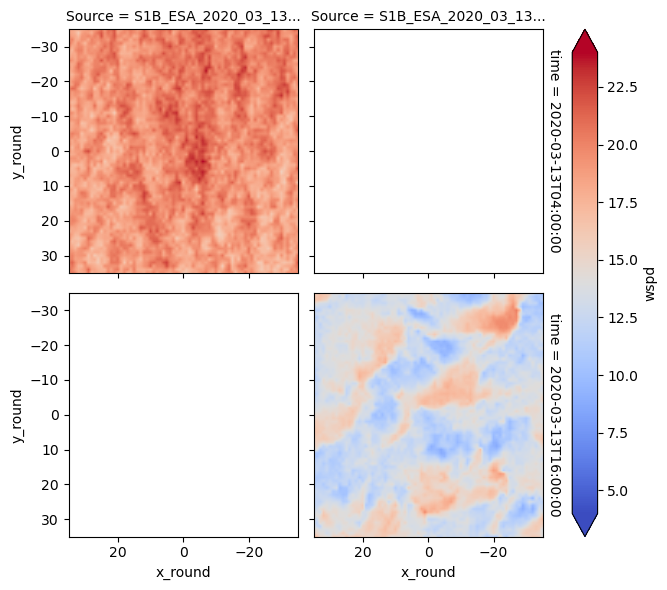

In [9]:
da_stat_ststst.plot(row='time',col='Source',xlim=(-35,35),ylim=(-35,35),vmin=4,vmax=24,cmap='coolwarm')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

## Flip x and y axes

In [12]:
da_stat_ststst = da_stat_ststst.rename({'x_round':'y_round','y_round':'x_round'})
da_stat_ststst

<xarray.DataArray 'wspd' (Source: 2, time: 2, x_round: 1721, y_round: 1711)> Size: 94MB
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]],


       [[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]])
Coordinates:
  * y_round    (y_round) float64 14kB -85.0 -84.9 -84.8 -84.7 ... 85.8 85.9 86.0
  * x_round    (x_round) float64 14kB -86.0 -85.9 -85.8 -85.7 ... 85.8 85.9 86.0
  * time       (time) datetime64[ns] 16B 2020-03-13T04:00:00 2020-03-13T16:00:00
  * Source     (Source) <U83 664B 'S1B_ESA_2020_03_13_06_56_19_0637397779_006...
    time_diff  (Source) float64 16B 2.939 0.67

## Compute wind speed and perts from model outputs

In [13]:
df_col_2d['wspd'] = np.sqrt(pow(df_col_2d['us'],2.) + pow(df_col_2d['vs'],2.))
df_col_2d['wspd_pert'] = df_col_2d['wspd'].copy(deep=True)
for i in tqdm(np.arange(np.shape(df_col_2d['wspd_pert'])[1])): # times
    for j in tqdm(np.arange(np.shape(df_col_2d['wspd_pert'])[0])): # source
        df_col_2d['wspd_pert'][j,i,:,:] = df_col_2d['wspd_pert'][j,i,:,:] - np.nanmean(df_col_2d['wspd_pert'][j,i,:,:].data.ravel())

100%|██████████| 4/4 [00:00<00:00, 201.98it/s]

100%|██████████| 2/2 [00:00<00:00, 47.03it/s]


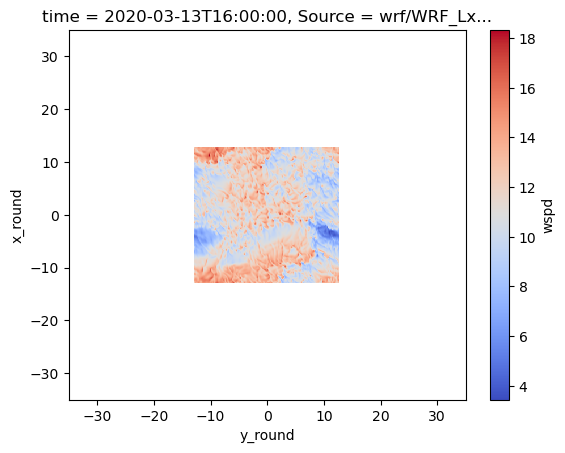

In [14]:
df_col_2d['wspd'][0,1,:,:].plot(xlim=(-35,35),ylim=(-35,35),zorder=2,cmap='coolwarm')

## Compute wind perts from SAR

In [15]:
sar_wspd_pert = da_stat_ststst.copy(deep=True)
sar_wspd_pert

<xarray.DataArray 'wspd' (Source: 2, time: 2, x_round: 1721, y_round: 1711)> Size: 94MB
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]],


       [[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]])
Coordinates:
  * y_round    (y_round) float64 14kB -85.0 -84.9 -84.8 -84.7 ... 85.8 85.9 86.0
  * x_round    (x_round) float64 14kB -86.0 -85.9 -85.8 -85.7 ... 85.8 85.9 86.0
  * time       (time) datetime64[ns] 16B 2020-03-13T04:00:00 2020-03-13T16:00:00
  * Source     (Source) <U83 664B 'S1B_ESA_2020_03_13_06_56_19_0637397779_006...
    time_diff  (Source) float64 16B 2.939 0.67

In [16]:
for i in np.arange(np.shape(sar_wspd_pert)[1]): # time
    if i < 1:
        sar_wspd_pert[0,i,:,:] = da_stat_ststst[0,i,:,:] - np.nanmean(da_stat_ststst[0,i,:,:].data.ravel())
    else:
        sar_wspd_pert[0,i,:,:] = da_stat_ststst[1,i,:,:] - np.nanmean(da_stat_ststst[1,i,:,:].data.ravel())
sar_wspd_pert.name = 'wspd_pert'

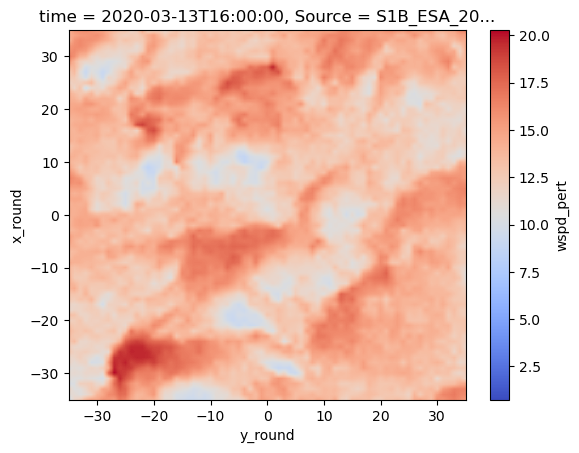

In [18]:
sar_wspd_pert[1,1,:,:].plot(xlim=(-35,35),ylim=(-35,35),zorder=2,cmap='coolwarm')

## Invert sar axes

In [19]:
sar_wspd_pert['x_round'] = -1.*sar_wspd_pert['x_round']
sar_wspd_pert['y_round'] = -1.*sar_wspd_pert['y_round']

## Merge obs and model and plot

In [20]:
ds_merge = xr.merge([df_col_2d['wspd'],da_stat_ststst.drop('time_diff')])['wspd']
ds_merge_pert = xr.merge([df_col_2d['wspd_pert'],sar_wspd_pert.drop('time_diff')])['wspd_pert']
ds_merge_pert

/tmp/ipykernel_1238/3139459018.py:1: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds_merge = xr.merge([df_col_2d['wspd'],da_stat_ststst.drop('time_diff')])['wspd']
/tmp/ipykernel_1238/3139459018.py:2: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds_merge_pert = xr.merge([df_col_2d['wspd_pert'],sar_wspd_pert.drop('time_diff')])['wspd_pert']


<xarray.DataArray 'wspd_pert' (Source: 6, time: 2, x_round: 1721, y_round: 1711)> Size: 283MB
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]],


       [[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
...
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]],


       [[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]])
Coordinates:
  * x_round  (x_round) float64 14kB -86.0 -85.9 -85.8 -85.7 ... 85.8 85.9 86.0
  * y_round  (y_round) float64 14kB -86.0 -85.9 -85.8 -85.7 ... 84.8 84.9 85.0
  * time     (time) datetime64[ns] 16B 2020-03-13T04:00:00 2020-03-13T16:00:00
  * Source   (Source) <U83 2kB 'S1B_ESA_2020_03_13_06_56_19_0637397779_006.43...

In [21]:
#ds_merge_pert = ds_merge_pert[:,:,[0,
#ds_merge_pert
ds_merge_pert = ds_merge_pert.where(ds_merge_pert.Source!=ds_merge_pert.Source[1], drop=True)
#ds_merge_pert

In [22]:
#plt.rcParams['font.size'] = 14 # Set global font size
plt.rcParams['axes.titlesize'] = 14 # Set title font size
plt.rcParams['axes.labelsize'] = 14 # Set axis label font size
plt.rcParams['xtick.labelsize'] = 14 # Set x-tick label font size
plt.rcParams['ytick.labelsize'] = 14 # Set y-tick label font size

In [23]:
ds_merge_pert

<xarray.DataArray 'wspd_pert' (Source: 5, time: 2, x_round: 1721, y_round: 1711)> Size: 236MB
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]],


       [[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
...
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]],


       [[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]])
Coordinates:
  * x_round  (x_round) float64 14kB -86.0 -85.9 -85.8 -85.7 ... 85.8 85.9 86.0
  * y_round  (y_round) float64 14kB -86.0 -85.9 -85.8 -85.7 ... 84.8 84.9 85.0
  * time     (time) datetime64[ns] 16B 2020-03-13T04:00:00 2020-03-13T16:00:00
  * Source   (Source) <U83 2kB 'S1B_ESA_2020_03_13_06_56_19_0637397779_006.43...

In [24]:
df_col_2d['wspd_pert']
#df_col_2d['wspd_pert'][0,0,:,:].plot(vmin=-5,vmax=5,xlim=(-35,35),ylim=(-35,35),zorder=2,cmap='coolwarm')

<xarray.DataArray 'wspd_pert' (Source: 4, time: 2, x_round: 1280, y_round: 1280)> Size: 105MB
array([[[[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         ...,
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]],

        [[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
...
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]],

        [[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         ...,
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]]]])
Coordinates:
  * x_round  (x_round) float64 10kB -64.0 -63.9 -63.8 -63.7 ... 63.7 63.8 63.9
  * y_round  (y_round) float64 10kB -64.0 -63.9 -63.8 -63.7 ... 63.7 63.8 63.9
  * time     (time) datetime64[ns] 16B 2020-03-13T04:00:00 2020-03-13T16:00:00
  * Source   (Source) <U49 784B 'wrf/WRF_Lx25_dx100_FixN_2D.nc' ... 'uclales-...

In [25]:
ds_merge_pert

<xarray.DataArray 'wspd_pert' (Source: 5, time: 2, x_round: 1721, y_round: 1711)> Size: 236MB
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]],


       [[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
...
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]],


       [[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]])
Coordinates:
  * x_round  (x_round) float64 14kB -86.0 -85.9 -85.8 -85.7 ... 85.8 85.9 86.0
  * y_round  (y_round) float64 14kB -86.0 -85.9 -85.8 -85.7 ... 84.8 84.9 85.0
  * time     (time) datetime64[ns] 16B 2020-03-13T04:00:00 2020-03-13T16:00:00
  * Source   (Source) <U83 2kB 'S1B_ESA_2020_03_13_06_56_19_0637397779_006.43...

## Plot flipped image for sanity check

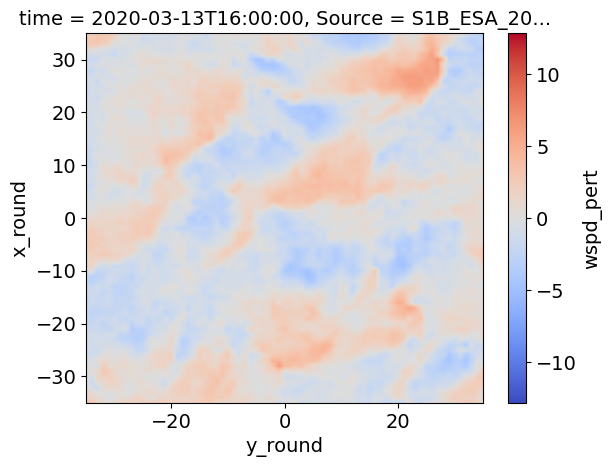

In [26]:
ds_merge_pert[0,1,:,:].plot(xlim=(-35,35),ylim=(-35,35),zorder=2,cmap='coolwarm')

In [27]:
df_col_2d

<xarray.Dataset> Size: 1GB
Dimensions:     (x_round: 1280, y_round: 1280, time: 2, Source: 4)
Coordinates:
  * x_round     (x_round) float64 10kB -64.0 -63.9 -63.8 ... 63.7 63.8 63.9
  * y_round     (y_round) float64 10kB -64.0 -63.9 -63.8 ... 63.7 63.8 63.9
  * time        (time) datetime64[ns] 16B 2020-03-13T04:00:00 2020-03-13T16:0...
  * Source      (Source) <U49 784B 'wrf/WRF_Lx25_dx100_FixN_2D.nc' ... 'uclal...
Data variables: (12/15)
    hfss        (Source, time, x_round, y_round) float64 105MB nan nan ... nan
    hfls        (Source, time, x_round, y_round) float64 105MB nan nan ... nan
    ustar       (Source, time, x_round, y_round) float64 105MB nan nan ... nan
    us          (Source, time, x_round, y_round) float64 105MB nan nan ... nan
    vs          (Source, time, x_round, y_round) float64 105MB nan nan ... nan
    pr          (Source, time, x_round, y_round) float64 105MB nan nan ... nan
    ...          ...
    alb         (Source, time, x_round, y_round) float64 105MB nan nan ... nan
    olr11       (Source, time, x_round, y_round) float64 105MB nan nan ... nan
    x_round_ph  (Source, x_round) float64 41kB nan nan nan nan ... nan nan nan
    y_round_ph  (Source, y_round) float64 41kB nan nan nan nan ... nan nan nan
    wspd        (Source, time, x_round, y_round) float64 105MB nan nan ... nan
    wspd_pert   (Source, time, x_round, y_round) float64 105MB nan nan ... nan
Attributes: (12/17)
    title:           WRF LES results for COMBLE-MIP case: fixed Nd and Ni
    reference:       https://github.com/ARM-Development/comble-mip
    authors:         Tim Juliano (tjuliano@ucar.edu)
    version:         2024-08-07 11:59:53
    format_version:  DEPHY SCM format version 1.6
    script:          convert_WRF_LES_output_to_dephy_format.ipynb
    ...              ...
    dx:              100.0 m
    dy:              100.0 m
    dz:              see ze variable
    nx:              256
    ny:              256
    nz:              159

## Create Fig. 7

In [28]:
os.chdir("/user-data-home/comble-mip/notebooks/plotting/paper/")

#ds_merge.plot(row='time',col='Source',vmin=16,vmax=24,xlim=(-35,35),ylim=(-35,35),cmap='coolwarm')
cf1 = ds_merge_pert.plot(aspect=1.1,row='time',col='Source',vmin=-5,vmax=5,xlim=(-35,35),ylim=(-35,35),zorder=2,cmap='coolwarm')
#cf1.axs[0,1].contour(df_col_2d['opt'][:,:,1,0].data)
#cf1 = ds_merge.plot(row='time',col='Source',vmin=5,vmax=25,xlim=(-35,35),ylim=(-35,35),cmap='coolwarm')

for i in np.arange(len(Time_Vec_model)):
    for j in np.arange(1,5):
        df_col_2d['lwp'][j-1,i,:,:].plot.contour(ax=cf1.axs[i,j-1],xlim=(-35,35),ylim=(-35,35),levels=[0.1],colors='k',zorder=3)
        #df_col_2d['alb'][j-1,i,:,:].plot.contour(ax=cf1.axs[i,j-1],xlim=(-35,35),ylim=(-35,35),levels=[0.5],colors='k',zorder=3)
        #cf2.set_ylabel('Distance [km]')

titles = ['SAR','DHARMA Production Domain','DHARMA Toy Domain','UCLALES-SALSA Toy Domain','WRF Toy Domain']
for i in np.arange(len(Time_Vec_model)):
    for j in np.arange(5):
        if i == 0:
            cf1.axs[i,j].set_title(titles[j])
        else:
            cf1.axs[i,j].set_title(' ')
        if j == 0:
            cf1.axs[i,j].set_ylabel('Distance [km]')
        else:
            cf1.axs[i,j].set_ylabel(' ')
for i in np.arange(5):
    cf1.axs[0,i].set_xlabel(' ')
    cf1.axs[-1,i].set_xlabel('Distance [km]')
cf1.cbar.set_label(label='Wind Speed Pert. [m s$^{-1}$]', size=14)
#plt.gca().invert_xaxis()
#plt.gca().invert_yaxis()
#for j in np.arange(2):
#cf1.axs[0,0].invert_xaxis()
#cf1.axs[1,0].invert_yaxis()
plt.savefig('sar_les_panel.png',dpi=600,bbox_inches='tight')
plt.close()
#plt.show()

/opt/conda/lib/python3.10/site-packages/matplotlib/contour.py:1454: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/opt/conda/lib/python3.10/site-packages/matplotlib/contour.py:1455: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
